In [42]:
pip install opendatasets

In [43]:
import opendatasets as od

In [44]:
download_url= "https://www.kaggle.com/datasets/splcher/animefacedataset"
od.download(download_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [45]:
import os
DATA_DIR= "./animefacedataset/"
print(os.listdir(DATA_DIR))

['images']


In [46]:
print(os.listdir(DATA_DIR+"/images"))

['53220_2016.jpg', '21459_2008.jpg', '45136_2014.jpg', '16822_2007.jpg', '26817_2009.jpg', '63203_2019.jpg', '49010_2015.jpg', '2748_2002.jpg', '44238_2013.jpg', '24942_2009.jpg', '30851_2010.jpg', '16328_2006.jpg', '48353_2014.jpg', '18481_2007.jpg', '8587_2004.jpg', '22061_2008.jpg', '19378_2007.jpg', '15361_2006.jpg', '17500_2007.jpg', '57991_2017.jpg', '24500_2009.jpg', '56231_2017.jpg', '44624_2013.jpg', '57499_2017.jpg', '27613_2009.jpg', '942_2000.jpg', '41009_2013.jpg', '50255_2015.jpg', '61916_2019.jpg', '42019_2013.jpg', '14336_2006.jpg', '30941_2010.jpg', '51737_2015.jpg', '7867_2004.jpg', '43718_2013.jpg', '4813_2003.jpg', '52531_2016.jpg', '60073_2018.jpg', '45931_2014.jpg', '51745_2015.jpg', '57224_2017.jpg', '32884_2011.jpg', '48113_2014.jpg', '55112_2016.jpg', '48485_2014.jpg', '63611_2019.jpg', '47910_2014.jpg', '3979_2002.jpg', '35984_2011.jpg', '61426_2018.jpg', '49149_2015.jpg', '4335_2003.jpg', '52600_2016.jpg', '53622_2016.jpg', '8463_2004.jpg', '31120_2010.jpg', 

In [47]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [48]:
image_size= 64
batch_size= 128
stats= (0.5,0.5,0.5), (0.5,0.5,0.5)

In [49]:
train_ds= ImageFolder(DATA_DIR,transform= T.Compose([
          T.Resize(image_size),
          T.CenterCrop(image_size),
          T.ToTensor(),
          T.Normalize(*stats)
]
))

In [50]:
train_dl= DataLoader(train_ds,batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [51]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [52]:
def denorm(img_tensors):
  return img_tensors* stats[1][0] +stats[0][0]

In [53]:
def show_images(images, nmax=64):
  fig, ax= plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))
def show_batch(dl,nmax=64):
  for images, _ in dl:
    show_images(images,nmax)
    break


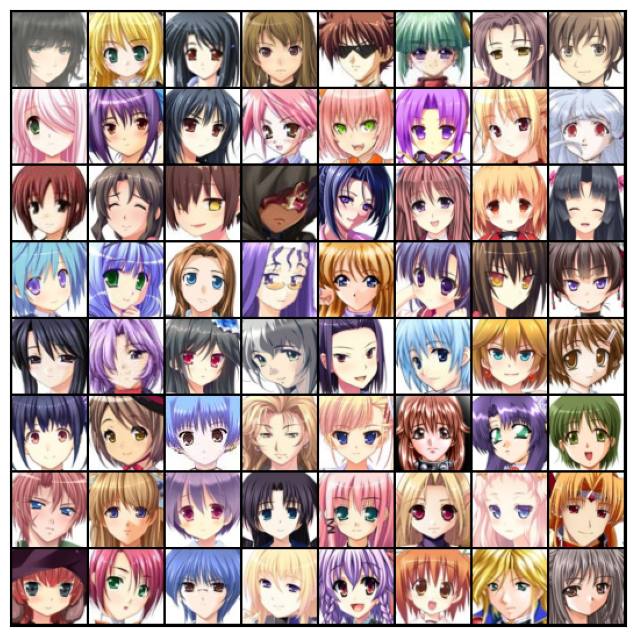

In [54]:
show_batch(train_dl)

**Using a GPU**


In [55]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
     return torch.device('cpu')

In [56]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]

  return data.to(device, non_blocking=True)


class DeviceDataLoader():
  def __init__(self,dl,device):
      self.dl=dl
      self.device=device

  def __iter__(self):
      for b in self.dl:
        yield to_device(b,self.device);
  def __len__(self):
    return len(self.dl)

In [57]:
device = get_default_device()
device

device(type='cuda')

In [58]:
train_dl= DeviceDataLoader(train_dl, device)

In [59]:
import torch.nn as nn

In [60]:
discriminator= nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64,128,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128,256,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256,512,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512,1, kernel_size=4, stride=1, padding=0,bias=False), # Changed stride to 1 and padding to 0

    nn.Flatten(),
    nn.Sigmoid()
)

In [61]:
discriminator= to_device(discriminator,device)

In [62]:
latent_size=128

In [63]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


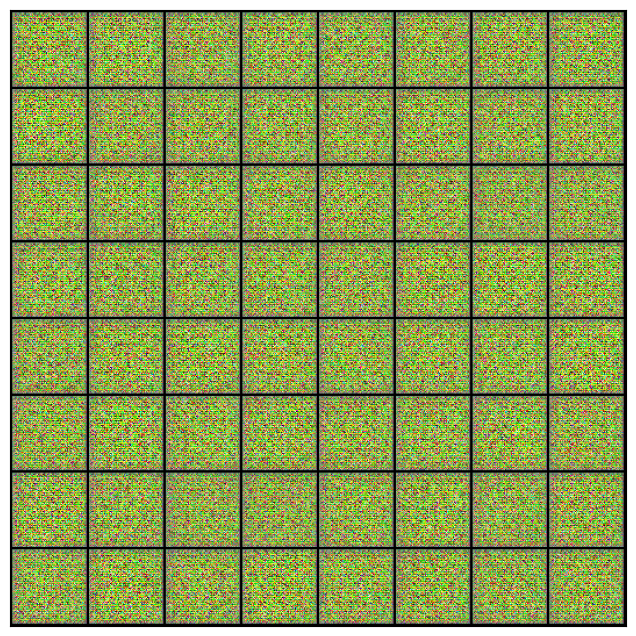

In [64]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [65]:
generator = to_device(generator, device)

In [66]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [67]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [68]:
from torchvision.utils import save_image

In [69]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [70]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [71]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


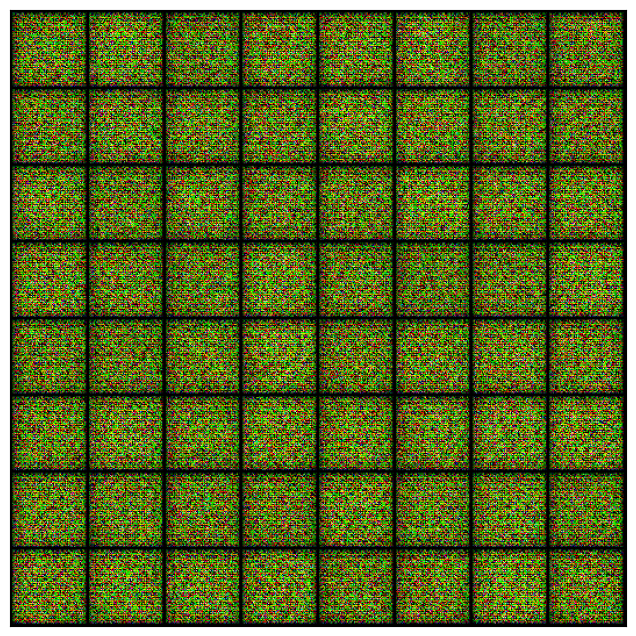

In [72]:
save_samples(0, fixed_latent)

In [73]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [74]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [79]:
lr = 0.0002
epochs = 1

In [80]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/1], loss_g: 6.3927, loss_d: 0.1519, real_score: 0.9649, fake_score: 0.0996
Saving generated-images-0001.png


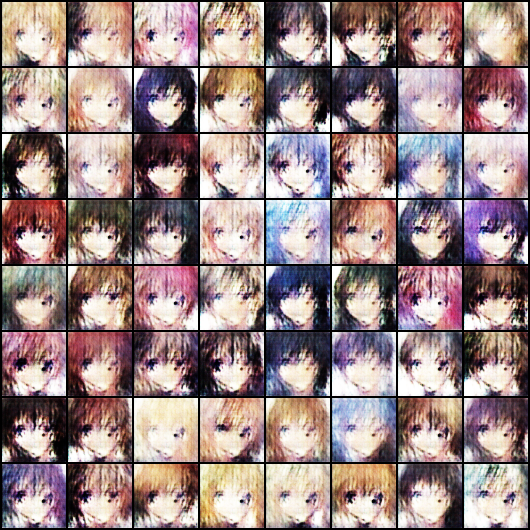

In [87]:
from IPython.display import Image
Image('./generated/generated-images-0004.png')

In [88]:
losses_g, losses_d, real_scores, fake_scores = history

In [89]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

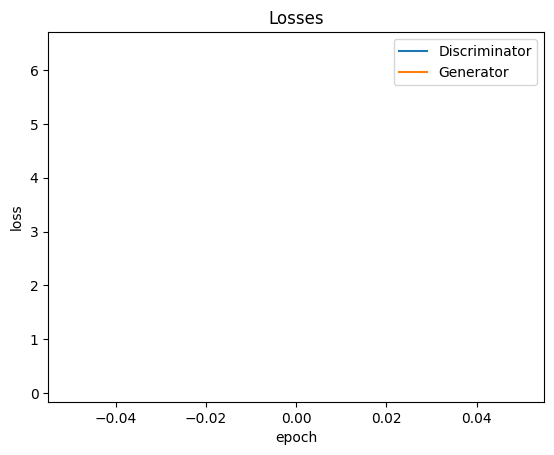

In [90]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');